In [2]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings

# Prepare Data

### Load Data

In [3]:
data = pd.read_csv("Software.csv")
data.head()

,user_id,rating,helpful_vote,title,text,verified_purchase
0,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,1.0,0,malware,mcaffee IS malware,False
1,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,5.0,0,Lots of Fun,I love playing tapped out because it is fun to...,True
2,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,5.0,0,Light Up The Dark,I love this flashlight app! It really illumin...,True
3,AH6CATODIVPVUOJEWHRSRCSKAOHA,4.0,0,Fun game,One of my favorite games,True
4,AEINY4XOINMMJCK5GZ3M6MMHBN6A,4.0,0,I am not that good at it but my kids are,Cute game. I am not that good at it but my kid...,True


## Handle Data

### Remove False Reviews

In [4]:
data = data[data["verified_purchase"]][["rating", "title", "text", "verified_purchase"]]
data.head()

,rating,title,text,verified_purchase
1,5.0,Lots of Fun,I love playing tapped out because it is fun to...,True
2,5.0,Light Up The Dark,I love this flashlight app! It really illumin...,True
3,4.0,Fun game,One of my favorite games,True
4,4.0,I am not that good at it but my kids are,Cute game. I am not that good at it but my kid...,True
5,4.0,good game,"Made me think , variety of the puzzles kept it...",True


In [5]:
data["verified_purchase"].describe()

count     4645281
unique          1
top          True
freq      4645281
Name: verified_purchase, dtype: object

In [6]:
data = data[["rating", "title", "text"]]
data.head()

,rating,title,text
1,5.0,Lots of Fun,I love playing tapped out because it is fun to...
2,5.0,Light Up The Dark,I love this flashlight app! It really illumin...
3,4.0,Fun game,One of my favorite games
4,4.0,I am not that good at it but my kids are,Cute game. I am not that good at it but my kid...
5,4.0,good game,"Made me think , variety of the puzzles kept it..."


### Handle Missing Data

In [7]:
data.dropna(inplace=True)

### Add Label

In [8]:
data['review'] = data['title'] + " " + data['text']
data.head()

,rating,title,text,review
1,5.0,Lots of Fun,I love playing tapped out because it is fun to...,Lots of Fun I love playing tapped out because ...
2,5.0,Light Up The Dark,I love this flashlight app! It really illumin...,Light Up The Dark I love this flashlight app! ...
3,4.0,Fun game,One of my favorite games,Fun game One of my favorite games
4,4.0,I am not that good at it but my kids are,Cute game. I am not that good at it but my kid...,I am not that good at it but my kids are Cute ...
5,4.0,good game,"Made me think , variety of the puzzles kept it...","good game Made me think , variety of the puzzl..."


#### Simple Sentiment Labelling

In [9]:
data['sentiment'] = data['rating'].apply(lambda x: 'Positive' if x >= 4 else 'Negative' if x <= 2 else 'Neutral')
data.dropna(inplace=True)
data.head()

,rating,title,text,review,sentiment
1,5.0,Lots of Fun,I love playing tapped out because it is fun to...,Lots of Fun I love playing tapped out because ...,Positive
2,5.0,Light Up The Dark,I love this flashlight app! It really illumin...,Light Up The Dark I love this flashlight app! ...,Positive
3,4.0,Fun game,One of my favorite games,Fun game One of my favorite games,Positive
4,4.0,I am not that good at it but my kids are,Cute game. I am not that good at it but my kid...,I am not that good at it but my kids are Cute ...,Positive
5,4.0,good game,"Made me think , variety of the puzzles kept it...","good game Made me think , variety of the puzzl...",Positive


In [10]:
data['sentiment'].value_counts()

sentiment
Positive    3399972
Negative     842540
Neutral      399863
Name: count, dtype: int64

In [11]:
# Text Cleaning Function
def clean_text(text):
    text = ' '.join(text.split())  # Remove extra spaces
    return text.lower()  # Convert to lowercase



In [12]:
data['review'] = data['review'].apply(clean_text)

In [13]:
data.head()

,rating,title,text,review,sentiment
1,5.0,Lots of Fun,I love playing tapped out because it is fun to...,lots of fun i love playing tapped out because ...,Positive
2,5.0,Light Up The Dark,I love this flashlight app! It really illumin...,light up the dark i love this flashlight app! ...,Positive
3,4.0,Fun game,One of my favorite games,fun game one of my favorite games,Positive
4,4.0,I am not that good at it but my kids are,Cute game. I am not that good at it but my kid...,i am not that good at it but my kids are cute ...,Positive
5,4.0,good game,"Made me think , variety of the puzzles kept it...","good game made me think , variety of the puzzl...",Positive


In [14]:
data['rating'] = data['rating'].astype(int)
data.head()

,rating,title,text,review,sentiment
1,5,Lots of Fun,I love playing tapped out because it is fun to...,lots of fun i love playing tapped out because ...,Positive
2,5,Light Up The Dark,I love this flashlight app! It really illumin...,light up the dark i love this flashlight app! ...,Positive
3,4,Fun game,One of my favorite games,fun game one of my favorite games,Positive
4,4,I am not that good at it but my kids are,Cute game. I am not that good at it but my kid...,i am not that good at it but my kids are cute ...,Positive
5,4,good game,"Made me think , variety of the puzzles kept it...","good game made me think , variety of the puzzl...",Positive


## Split to Train and Test file

In [15]:
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42,stratify=data["rating"])

In [16]:
train_data

,rating,title,text,review,sentiment
371672,5,Five Stars,Great bright light!,five stars great bright light!,Positive
4187323,5,LOVE THIS GAME,I love this game it's better than Slither.I'm,love this game i love this game it's better th...,Positive
4321603,5,Awesome,This game is so so so so so so fun I love it a...,awesome this game is so so so so so so fun i l...,Positive
1311779,1,Not having to upgrade,Didn't like. Game goes until it asks too upgrade.,not having to upgrade didn't like. game goes u...,Negative
2779003,1,One Star,could not get game to work,one star could not get game to work,Negative
...,...,...,...,...,...
4836140,4,An extremely fun game!,"This game is addictive, it seems easy at first...","an extremely fun game! this game is addictive,...",Positive
4093878,5,great game!,"Try this game, you'll love every minute of it!!!","great game! try this game, you'll love every m...",Positive
1988839,5,Fun,I love playing rummy and with this game I do n...,fun i love playing rummy and with this game i ...,Positive
3489530,5,Minecraft is life.,"Loved the game from the begining, touchscreen ...",minecraft is life. loved the game from the beg...,Positive


In [17]:
test_data

,rating,title,text,review,sentiment
3383843,3,fun,The game is fun and time consuming. Takes pati...,fun the game is fun and time consuming. takes ...,Neutral
1623340,1,please fix,I can no longer play on either of my kindles. ...,please fix i can no longer play on either of m...,Negative
4563392,5,Great!,I love this app! It can keep you busy! It actu...,great! i love this app! it can keep you busy! ...,Positive
2164685,5,"Highly addictive, fun and challenging!",Love this game. It's addictive and challenging...,"highly addictive, fun and challenging! love th...",Positive
4104104,5,Great product!,Can get everything on it. Flexible and free. W...,great product! can get everything on it. flexi...,Positive
...,...,...,...,...,...
2285729,5,Great game to keep your mind sharp,Makes you think,great game to keep your mind sharp makes you t...,Positive
3971964,5,LOVE IT LOVE IT LOVE IT!!!,This game is fun and addicting! It's good for ...,love it love it love it!!! this game is fun an...,Positive
2750467,5,Splashtastic,Loving this game! Nice way to recover and recu...,splashtastic loving this game! nice way to rec...,Positive
1368987,5,Streaming,Never use it,streaming never use it,Positive


### Distribution Of Train Data

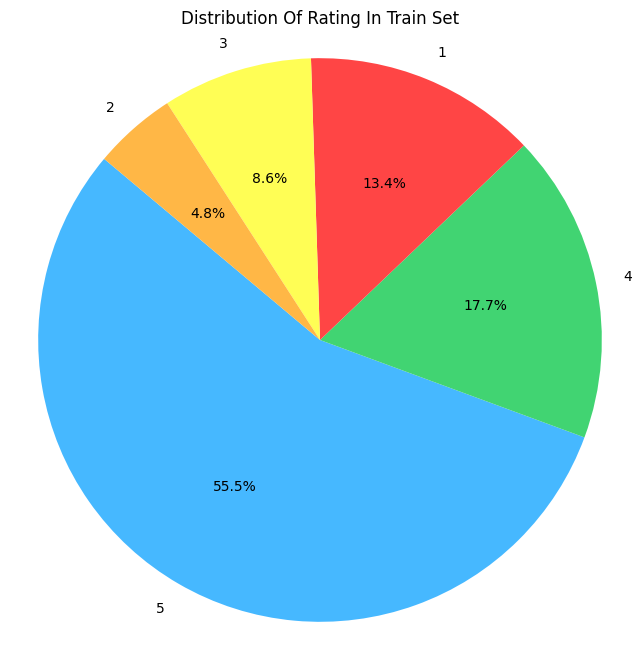

In [18]:
plt.figure(figsize=(8, 8))
labels = train_data['rating'].value_counts().index
sizes = train_data['rating'].value_counts().values
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#46b8ff', '#41d472', '#ff4545', '#fffe55', '#ffb746'])
plt.title('Distribution Of Rating In Train Set')
plt.axis('equal')
plt.show()

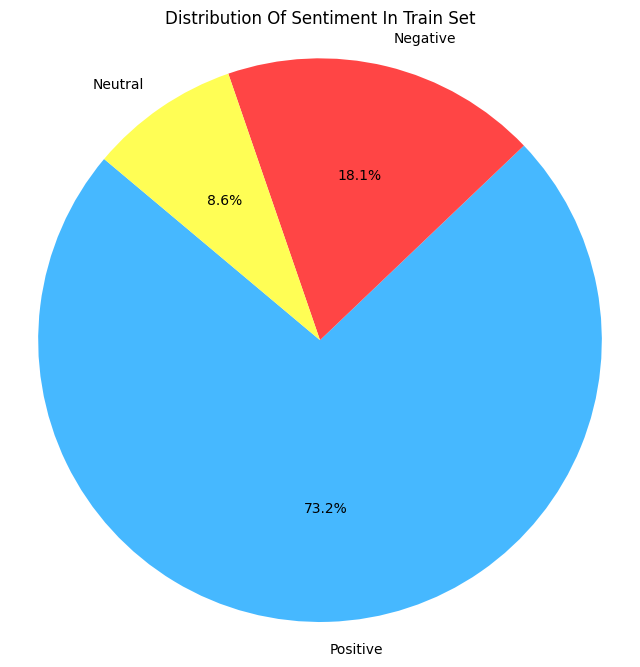

In [19]:
plt.figure(figsize=(8, 8))
labels = train_data['sentiment'].value_counts().index
sizes = train_data['sentiment'].value_counts().values
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#46b8ff', '#ff4545', '#fffe55'])
plt.title('Distribution Of Sentiment In Train Set')
plt.axis('equal')
plt.show()

### Distribution Of Test Data

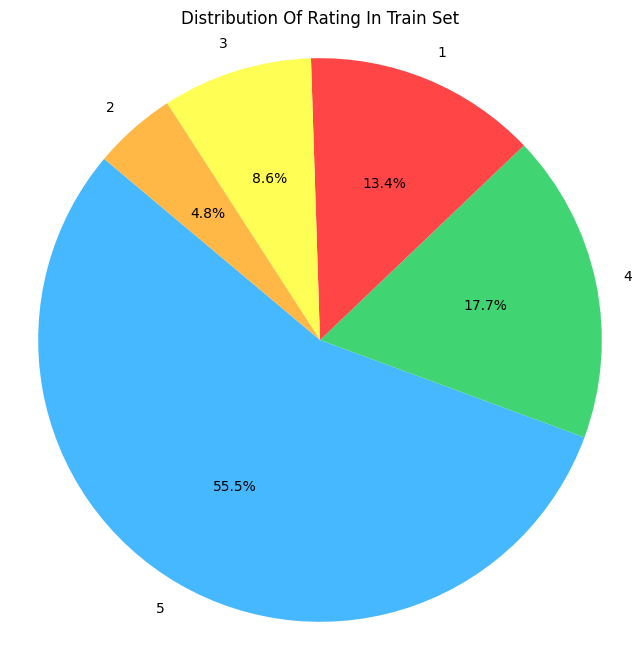

In [20]:
plt.figure(figsize=(8, 8))
labels = test_data['rating'].value_counts().index
sizes = test_data['rating'].value_counts().values
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#46b8ff', '#41d472', '#ff4545', '#fffe55', '#ffb746'])
plt.title('Distribution Of Rating In Train Set')
plt.axis('equal')
plt.show()

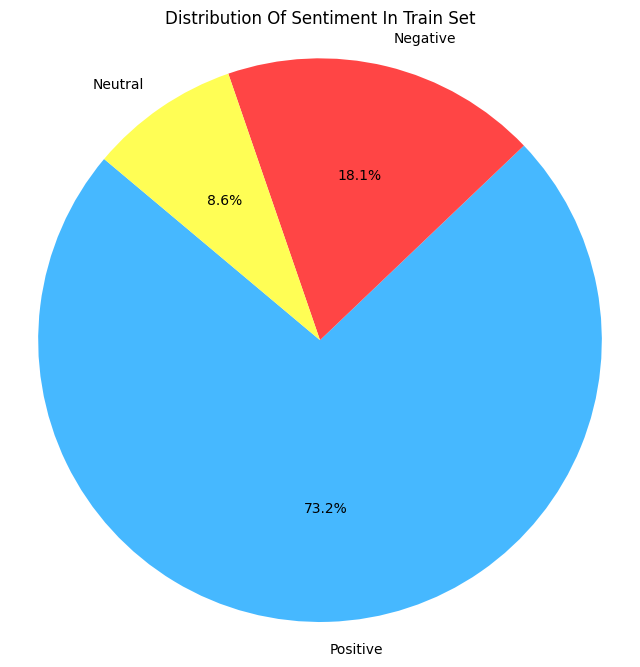

In [21]:
plt.figure(figsize=(8, 8))
labels = test_data['sentiment'].value_counts().index
sizes = test_data['sentiment'].value_counts().values
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#46b8ff', '#ff4545', '#fffe55'])
plt.title('Distribution Of Sentiment In Train Set')
plt.axis('equal')
plt.show()

### Save CSV

In [22]:
train_data.to_csv("training.csv", index=False)
test_data.to_csv("test.csv", index=False)

In [23]:
data = ''

# Train Models

In [ ]:
#train_data = pd.read_csv("training.csv")
#test_data = pd.read_csv("test.csv")

### Undersampling Data

In [27]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3249662 entries, 371672 to 2504737
Data columns (total 5 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   rating     int32 
 1   title      object
 2   text       object
 3   review     object
 4   sentiment  object
dtypes: int32(1), object(4)
memory usage: 136.4+ MB


In [29]:
# Undersampling
undersampler = RandomUnderSampler()
x_train, y_train = undersampler.fit_resample(train_data['review'].values.reshape(-1, 1), train_data['rating'])

## LinearSVC

In [34]:
%%time
pipeline = make_pipeline(
    TfidfVectorizer(),
    LinearSVC(C=0.1)
)
pipeline.fit(x_train.ravel(), y_train)

# Calibrated Classifier for predict_proba
clf = CalibratedClassifierCV(pipeline)
clf.fit(x_train.ravel(), y_train)
joblib.dump(clf, 'clf-pipeline.joblib')

CPU times: total: 6min 25s
Wall time: 6min 39s


['clf-pipeline.joblib']

## MultinomialNB

In [31]:
%%time
pipeline = make_pipeline(
    TfidfVectorizer(),
    MultinomialNB()
)
pipeline.fit(x_train.ravel(), y_train)
joblib.dump(pipeline, 'MNB-pipeline.joblib')

CPU times: total: 20.4 s
Wall time: 24.6 s


['MNB-pipeline.joblib']

## LogisticRegression

In [32]:
%%time
pipeline = make_pipeline(
    TfidfVectorizer(),
    LogisticRegression(solver="lbfgs", max_iter=1000, n_jobs=-1)
)
pipeline.fit(x_train.ravel(), y_train)
joblib.dump(pipeline, 'LR-pipeline.joblib')

CPU times: total: 21.6 s
Wall time: 4min 25s


['LR-pipeline.joblib']

## SGDClassifier

In [33]:
%%time
pipeline = make_pipeline(
    TfidfVectorizer(),
    SGDClassifier(loss='log_loss',n_jobs=-1)
)
pipeline.fit(x_train.ravel(), y_train)
joblib.dump(pipeline, 'SGDC-pipeline.joblib')

CPU times: total: 33.9 s
Wall time: 28.7 s


['SGDC-pipeline.joblib']

## Ensemble Model

In [35]:
from sklearn.ensemble import VotingClassifier

In [36]:
clf1 = MultinomialNB()
clf2 = LogisticRegression(solver="lbfgs", max_iter=1000, n_jobs=-1)
clf3 =SGDClassifier(loss='log_loss',n_jobs=-1)
clf4 = LinearSVC(C=0.1)

In [37]:
%%time
pipeline = make_pipeline(
    TfidfVectorizer(),
    VotingClassifier(estimators=[
        ('mnb', clf1),
        ('lor', clf2),
        ('sgdc', clf3)], voting='soft')
)
pipeline.fit(x_train.ravel(), y_train)
joblib.dump(pipeline, 'voting3-clf-pipeline.joblib')


CPU times: total: 35.7 s
Wall time: 3min 51s


['voting3-clf-pipeline.joblib']

In [38]:
%%time
pipeline = make_pipeline(
    TfidfVectorizer(),
    VotingClassifier(estimators=[
        ('mnb', clf1),
        ('lor', clf2),
        ('sgdc', clf3),
        ('svc', clf4)], voting='soft')
)
pipeline.fit(x_train.ravel(), y_train)
joblib.dump(pipeline, 'voting4-clf-pipeline.joblib')


CPU times: total: 1min 32s
Wall time: 4min 45s


['voting4-clf-pipeline.joblib']

# Evalution Models

In [42]:
from sklearn.metrics import classification_report, confusion_matrix

In [40]:
x_test, y_test = test_data['review'], test_data['rating']
y_test_sentiment = test_data['sentiment']

In [39]:
# Load Pipelines
lsvc = joblib.load("clf-pipeline.joblib")
mnb = joblib.load("MNB-pipeline.joblib")
lor = joblib.load("LR-pipeline.joblib")
sgdc = joblib.load("SGDC-pipeline.joblib")
v3_clf = joblib.load('voting3-clf-pipeline.joblib')
v4_clf = joblib.load('voting4-clf-pipeline.joblib')

In [47]:
def map_probabilities_to_sentiment(proba):
    negative = proba[:,0] + proba[:,1]
    neutral = proba[:,2]
    positive = proba[:,3] + proba[:,4]
    
    sentiment = np.where((negative >= neutral) & (negative >= positive), 'Negative',
                np.where((neutral >= negative) & (neutral >= positive), 'Neutral', 'Positive'))
    return sentiment

## LinearSVC

Accuracy For Predict Rating: 0.6711957165618473
              precision    recall  f1-score   support

           1       0.73      0.75      0.74    186400
           2       0.29      0.53      0.37     66362
           3       0.42      0.48      0.45    119959
           4       0.44      0.54      0.49    247114
           5       0.89      0.74      0.80    772878

    accuracy                           0.67   1392713
   macro avg       0.55      0.61      0.57   1392713
weighted avg       0.72      0.67      0.69   1392713



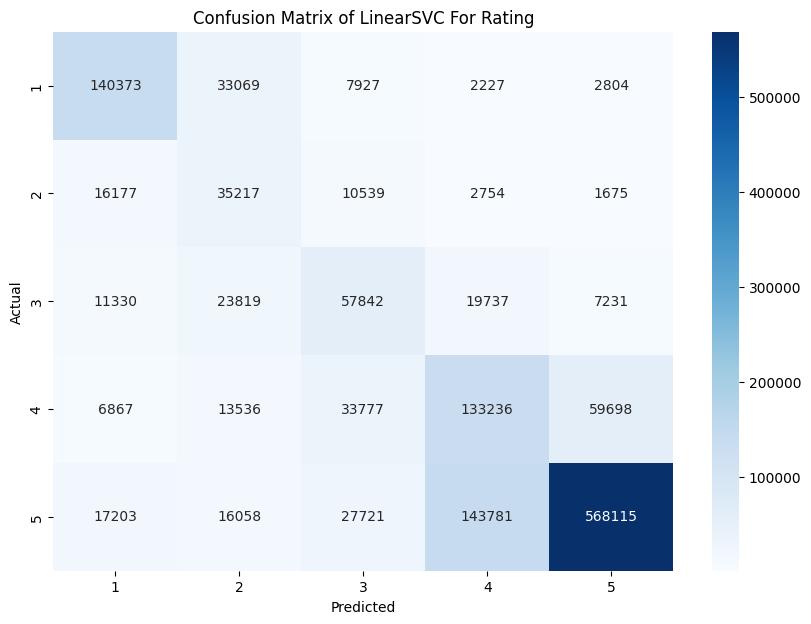

CPU times: total: 2min 45s
Wall time: 3min 1s


In [54]:
%%time
y_pred = lsvc.predict(x_test)
print("Accuracy For Predict Rating:", accuracy_score(y_test, y_pred))
print(classification_report(y_test,y_pred))


# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['1', '2', '3','4','5'], 
            yticklabels=['1', '2', '3','4', '5'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of LinearSVC For Rating')
plt.show()

Accuracy For Predict Sentiment: 0.8673000108421477
              precision    recall  f1-score   support

    Negative       0.70      0.92      0.79    252762
     Neutral       0.53      0.39      0.45    119959
    Positive       0.96      0.91      0.93   1019992

    accuracy                           0.87   1392713
   macro avg       0.73      0.74      0.72   1392713
weighted avg       0.87      0.87      0.87   1392713



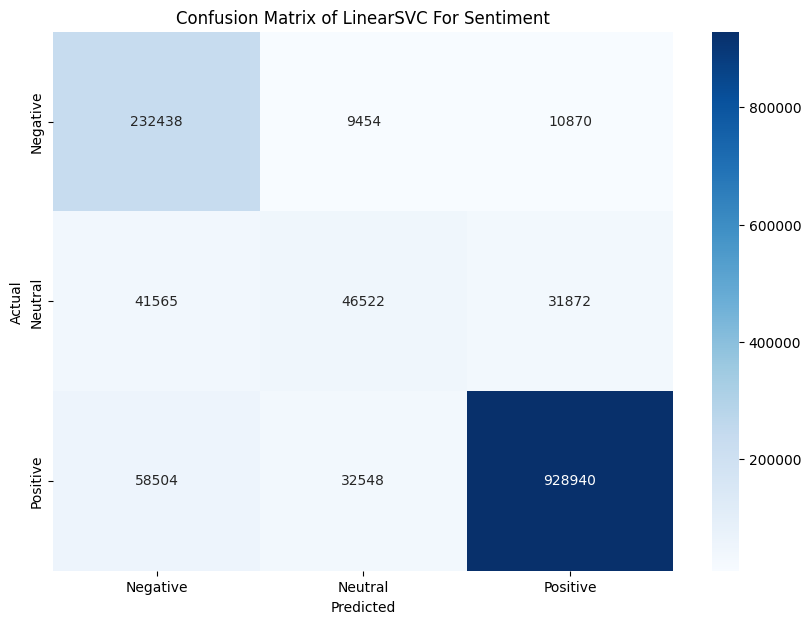

CPU times: total: 3min 27s
Wall time: 3min 40s


In [55]:
%%time
y_pred_proba = lsvc.predict_proba(x_test)
y_pred_sentiment = map_probabilities_to_sentiment(y_pred_proba)
print("Accuracy For Predict Sentiment:", accuracy_score(y_test_sentiment, y_pred_sentiment))
print(classification_report(y_test_sentiment,y_pred_sentiment))

# Plot confusion matrix
cm = confusion_matrix(y_test_sentiment, y_pred_sentiment)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Neutral', 'Positive'], 
            yticklabels=['Negative', 'Neutral', 'Positive',])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of LinearSVC For Sentiment')
plt.show()

## MultinomialNB

Accuracy For Predict Rating: 0.6110304133012329
              precision    recall  f1-score   support

           1       0.67      0.71      0.69    186400
           2       0.22      0.55      0.32     66362
           3       0.40      0.45      0.42    119959
           4       0.39      0.55      0.46    247114
           5       0.90      0.64      0.75    772878

    accuracy                           0.61   1392713
   macro avg       0.52      0.58      0.53   1392713
weighted avg       0.70      0.61      0.64   1392713



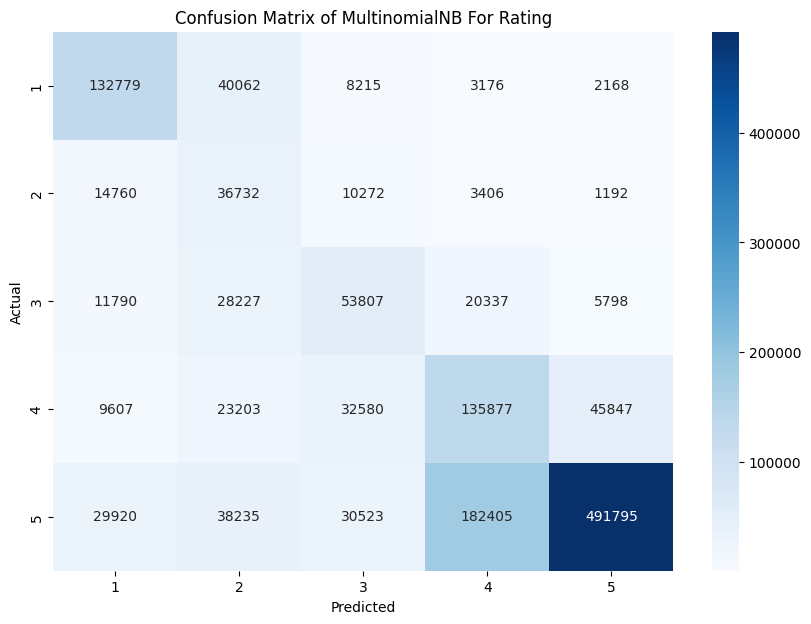

CPU times: total: 36.3 s
Wall time: 37.6 s


In [56]:
%%time
y_pred = mnb.predict(x_test)
print("Accuracy For Predict Rating:", accuracy_score(y_test, y_pred))
print(classification_report(y_test,y_pred))


# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['1', '2', '3','4','5'], 
            yticklabels=['1', '2', '3','4', '5'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of MultinomialNB For Rating')
plt.show()

Accuracy For Predict Sentiment: 0.8279265002911583
              precision    recall  f1-score   support

    Negative       0.57      0.93      0.71    252762
     Neutral       0.66      0.27      0.38    119959
    Positive       0.95      0.87      0.91   1019992

    accuracy                           0.83   1392713
   macro avg       0.73      0.69      0.67   1392713
weighted avg       0.85      0.83      0.83   1392713



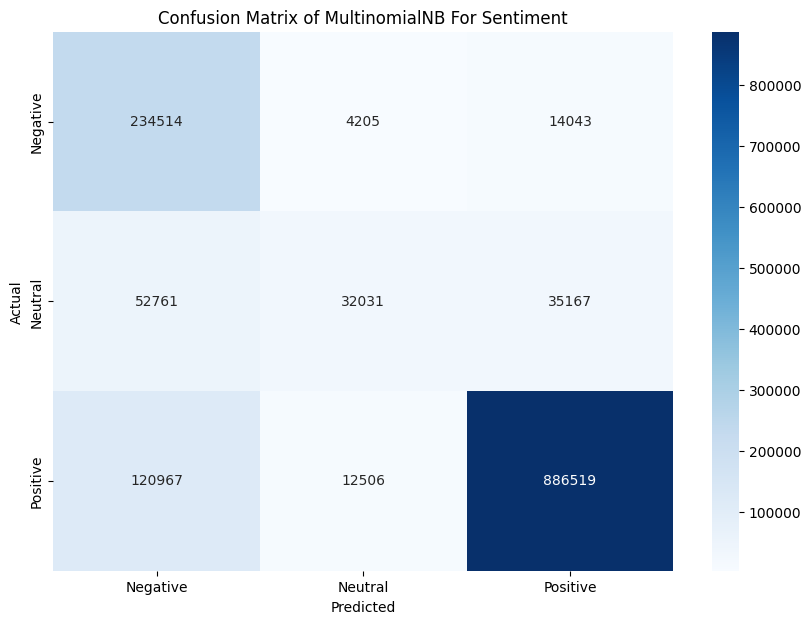

CPU times: total: 1min 14s
Wall time: 1min 17s


In [57]:
%%time
y_pred_proba = mnb.predict_proba(x_test)
y_pred_sentiment = map_probabilities_to_sentiment(y_pred_proba)
print("Accuracy For Predict Sentiment:", accuracy_score(y_test_sentiment, y_pred_sentiment))
print(classification_report(y_test_sentiment,y_pred_sentiment))

# Plot confusion matrix
cm = confusion_matrix(y_test_sentiment, y_pred_sentiment)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Neutral', 'Positive'], 
            yticklabels=['Negative', 'Neutral', 'Positive',])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of MultinomialNB For Sentiment')
plt.show()

## LogisticRegression

Accuracy For Predict Rating: 0.6662628983860996
              precision    recall  f1-score   support

           1       0.75      0.74      0.75    186400
           2       0.30      0.54      0.39     66362
           3       0.40      0.50      0.45    119959
           4       0.43      0.54      0.48    247114
           5       0.89      0.72      0.80    772878

    accuracy                           0.67   1392713
   macro avg       0.56      0.61      0.57   1392713
weighted avg       0.72      0.67      0.69   1392713



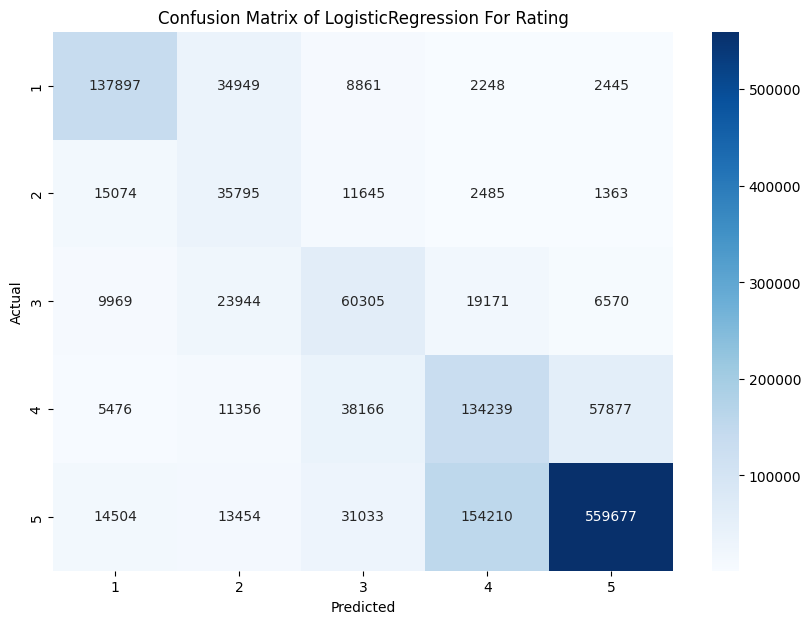

CPU times: total: 35.3 s
Wall time: 38.6 s


In [58]:
%%time
y_pred = lor.predict(x_test)
print("Accuracy For Predict Rating:", accuracy_score(y_test, y_pred))
print(classification_report(y_test,y_pred))


# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['1', '2', '3','4','5'], 
            yticklabels=['1', '2', '3','4', '5'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of LogisticRegression For Rating')
plt.show()

Accuracy For Predict Sentiment: 0.8678808914686659
              precision    recall  f1-score   support

    Negative       0.71      0.92      0.80    252762
     Neutral       0.50      0.41      0.45    119959
    Positive       0.96      0.91      0.93   1019992

    accuracy                           0.87   1392713
   macro avg       0.72      0.74      0.73   1392713
weighted avg       0.87      0.87      0.87   1392713



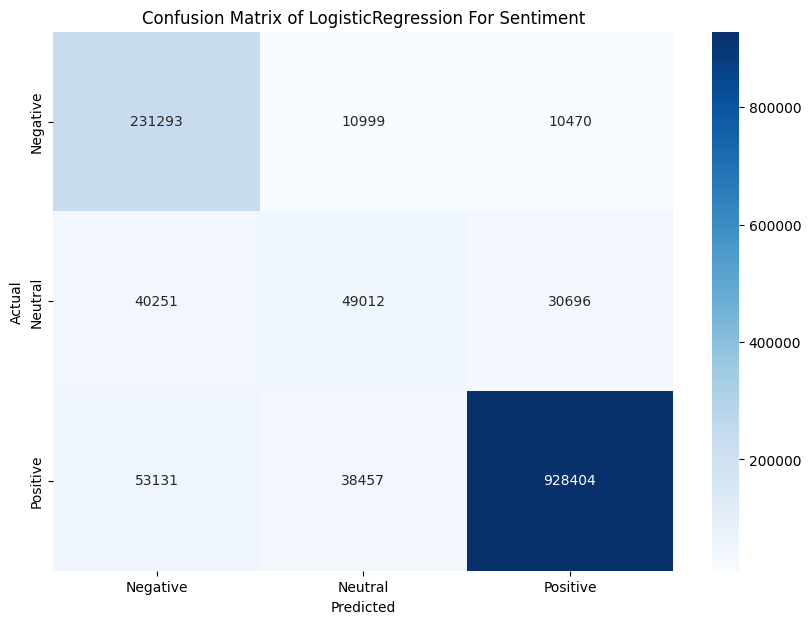

CPU times: total: 1min 15s
Wall time: 1min 20s


In [59]:
%%time
y_pred_proba = lor.predict_proba(x_test)
y_pred_sentiment = map_probabilities_to_sentiment(y_pred_proba)
print("Accuracy For Predict Sentiment:", accuracy_score(y_test_sentiment, y_pred_sentiment))
print(classification_report(y_test_sentiment,y_pred_sentiment))

# Plot confusion matrix
cm = confusion_matrix(y_test_sentiment, y_pred_sentiment)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Neutral', 'Positive'], 
            yticklabels=['Negative', 'Neutral', 'Positive',])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of LogisticRegression For Sentiment')
plt.show()

## SGDClassifier

Accuracy For Predict Rating: 0.6624085507925898
              precision    recall  f1-score   support

           1       0.66      0.77      0.71    186400
           2       0.28      0.50      0.36     66362
           3       0.43      0.47      0.45    119959
           4       0.45      0.52      0.48    247114
           5       0.88      0.73      0.80    772878

    accuracy                           0.66   1392713
   macro avg       0.54      0.60      0.56   1392713
weighted avg       0.71      0.66      0.68   1392713



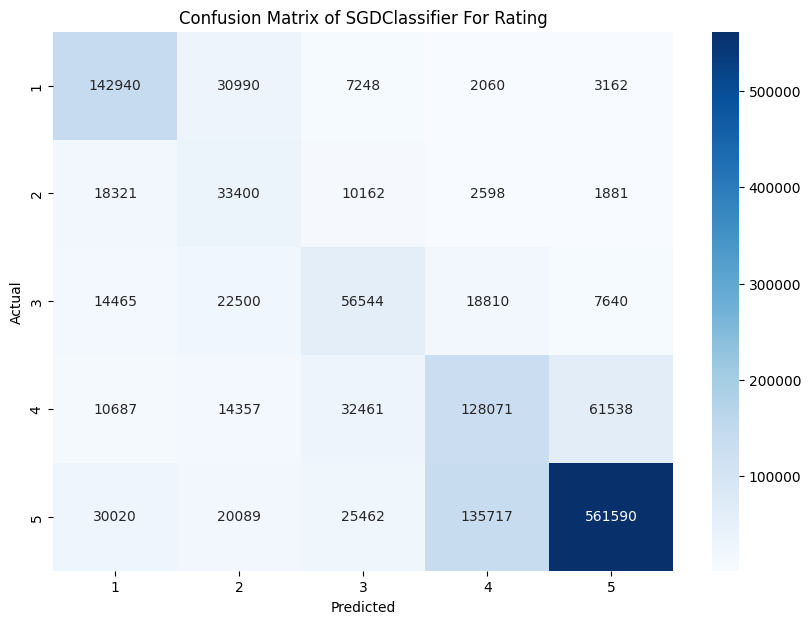

CPU times: total: 36.7 s
Wall time: 37.9 s


In [60]:
%%time
y_pred = sgdc.predict(x_test)
print("Accuracy For Predict Rating:", accuracy_score(y_test, y_pred))
print(classification_report(y_test,y_pred))


# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['1', '2', '3','4','5'], 
            yticklabels=['1', '2', '3','4', '5'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of SGDClassifier For Rating')
plt.show()

Accuracy For Predict Sentiment: 0.851490579896935
              precision    recall  f1-score   support

    Negative       0.63      0.93      0.75    252762
     Neutral       0.62      0.30      0.41    119959
    Positive       0.95      0.90      0.92   1019992

    accuracy                           0.85   1392713
   macro avg       0.73      0.71      0.69   1392713
weighted avg       0.86      0.85      0.85   1392713



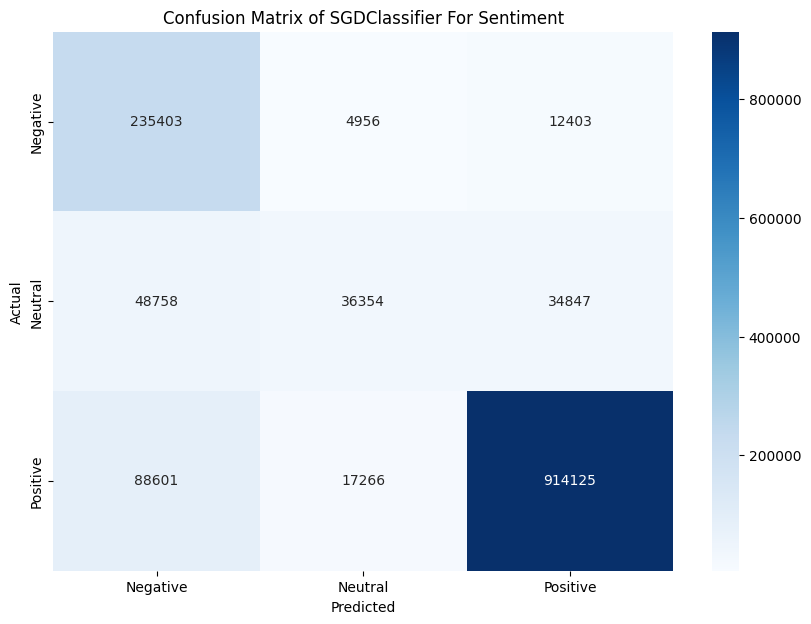

CPU times: total: 1min 15s
Wall time: 1min 17s


In [61]:
%%time
y_pred_proba = sgdc.predict_proba(x_test)
y_pred_sentiment = map_probabilities_to_sentiment(y_pred_proba)
print("Accuracy For Predict Sentiment:", accuracy_score(y_test_sentiment, y_pred_sentiment))
print(classification_report(y_test_sentiment,y_pred_sentiment))

# Plot confusion matrix
cm = confusion_matrix(y_test_sentiment, y_pred_sentiment)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Neutral', 'Positive'], 
            yticklabels=['Negative', 'Neutral', 'Positive',])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of SGDClassifier For Sentiment')
plt.show()

## Voting 3 pipelines

Accuracy For Predict Rating: 0.6629772250276977
              precision    recall  f1-score   support

           1       0.72      0.75      0.74    186400
           2       0.28      0.55      0.37     66362
           3       0.42      0.49      0.45    119959
           4       0.43      0.55      0.48    247114
           5       0.90      0.72      0.80    772878

    accuracy                           0.66   1392713
   macro avg       0.55      0.61      0.57   1392713
weighted avg       0.72      0.66      0.68   1392713



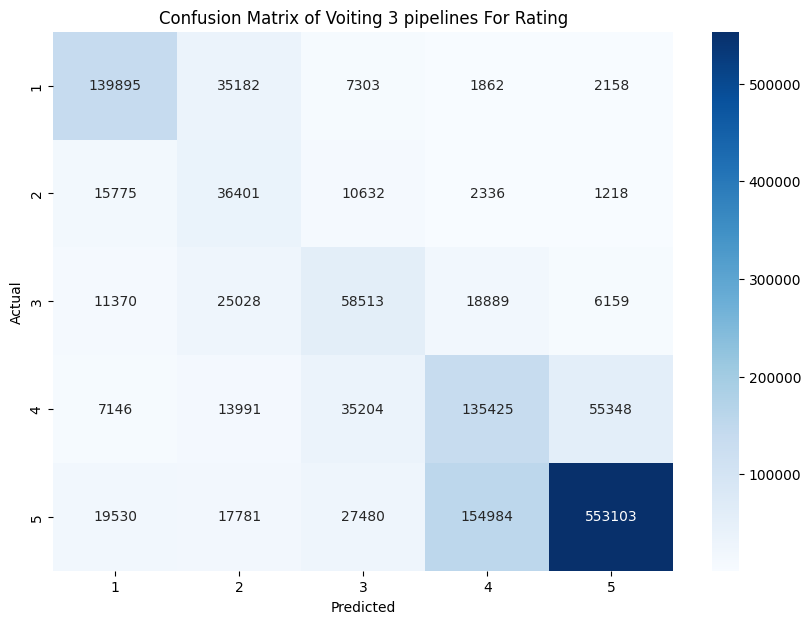

CPU times: total: 37.5 s
Wall time: 38.8 s


In [62]:
%%time
y_pred = v3_clf.predict(x_test)
print("Accuracy For Predict Rating:", accuracy_score(y_test, y_pred))
print(classification_report(y_test,y_pred))


# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['1', '2', '3','4','5'], 
            yticklabels=['1', '2', '3','4', '5'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Voiting 3 pipelines For Rating')
plt.show()

Accuracy For Predict Sentiment: 0.863014849434162
              precision    recall  f1-score   support

    Negative       0.66      0.94      0.78    252762
     Neutral       0.59      0.34      0.43    119959
    Positive       0.96      0.91      0.93   1019992

    accuracy                           0.86   1392713
   macro avg       0.74      0.73      0.71   1392713
weighted avg       0.87      0.86      0.86   1392713



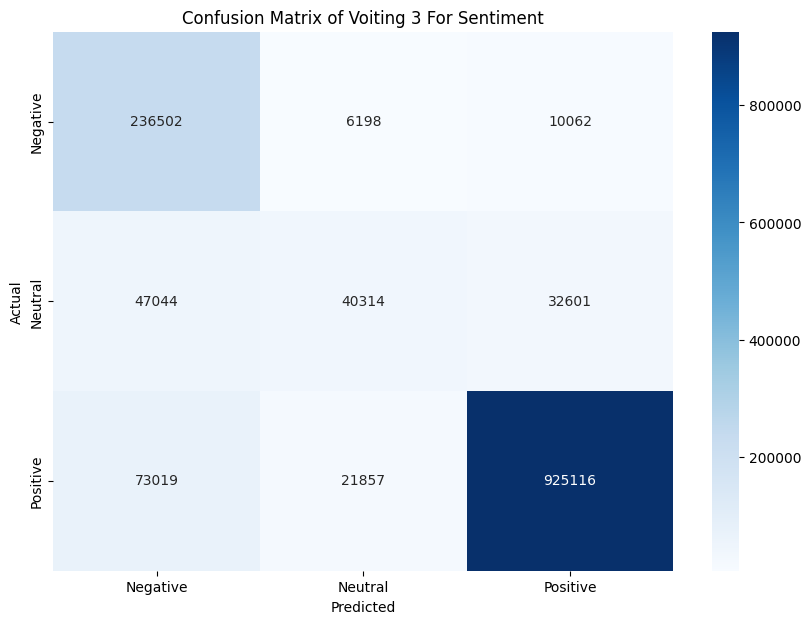

CPU times: total: 1min 15s
Wall time: 1min 18s


In [63]:
%%time
y_pred_proba = v3_clf.predict_proba(x_test)
y_pred_sentiment = map_probabilities_to_sentiment(y_pred_proba)
print("Accuracy For Predict Sentiment:", accuracy_score(y_test_sentiment, y_pred_sentiment))
print(classification_report(y_test_sentiment,y_pred_sentiment))

# Plot confusion matrix
cm = confusion_matrix(y_test_sentiment, y_pred_sentiment)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Neutral', 'Positive'], 
            yticklabels=['Negative', 'Neutral', 'Positive',])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Voiting 3 For Sentiment')
plt.show()